# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
from numba import jit

# Parameters

In [3]:
nx = 51 # number of continuity/scalar/pressure control volumes in x-direction
ny = 51 # number of continuity/scalar/pressure control volumes in y-direction
x_min, x_max = 0., 10.
y_min, y_max = 0., 1.
dx = (x_max-x_min)/nx
dy = (y_max-y_min)/ny
# Set fluid properties
μ = 0.01
ρ = 1.0

# number of outer iterations
outer_iterations = 1000

# set relaxation factors
ω_u = 0.7 # x-momentum under-relaxation
ω_v = 0.7 # y-momentum under-relaxation
ω_p = 0.3 # pressure update under-relaxation

# SOR over-relaxation factor
Ω = 1.7

# Initialize Arrays

Initialize variables for channel flow, <br>
+ $u=0, v=0, p=0$ <br>

Set the boundary conditions,
+ inlet / inflow at the left boundary
+ upper wall
+ bottom wall

In [4]:
u = np.zeros([ny+2,nx+2])
v = np.zeros([ny+2,nx+2])
p = np.zeros([ny+2,nx+2])
u_old = np.zeros([ny+2,nx+2])
v_old = np.zeros([ny+2,nx+2])
p_corr = np.zeros([ny+2,nx+2])

Apu = np.ones([ny+2,nx+2])
Apv = np.ones([ny+2,nx+2])
App = np.ones([ny+2,nx+2])
Ae = np.ones([ny+2,nx+2])
Aw = np.ones([ny+2,nx+2])
An = np.ones([ny+2,nx+2])
As = np.ones([ny+2,nx+2])

source = np.zeros([ny+2,nx+2])

u_nodal = np.zeros([ny+2,nx+2])
v_nodal = np.zeros([ny+2,nx+2])
p_nodal = np.zeros([ny+2,nx+2])
x_nodal = np.zeros([ny+2,nx+2])
y_nodal = np.zeros([ny+2,nx+2])
Vel_mag = np.zeros([ny+2,nx+2])

**Set inlet and wall boundary conditions for channel flow**

In [5]:
u[0,:] = 0.0 # zero on bottom wall, (for tangential component index starts with 0)
u[ny+1,:] = 0.0 # zero on upper wall 
u[:,1] = 1.0 # u=1 at inlet/left boundary (for normal component index starts with 1)
u[:,nx+1] = u[:,1] # set outlet to inlet; conserve mass overall

Initialize **u_old** and **v_old**

In [6]:
u_old[:,:] = u[:,:]
v_old[:,:] = v[:,:]

**Begin outer iterations for sequential loop procedure**

In [7]:
for outeriterations in range(1,outer_iterations+1):
    # X-momentum equation solution
    # set  x-momentum equation coefficients
    for j in range(1,ny+1):
        for i in range(2,nx+1):
            Ae[j,i] = max(-0.5*ρ*dy*(u_old[j,i+1]+u_old[j,i]),0.)+μ*dy/dx
            Aw[j,i] = max( 0.5*ρ*dy*(u_old[j,i-1]+u_old[j,i]),0.)+μ*dy/dx
            An[j,i] = max(-0.5*ρ*dx*(v_old[j+1,i]+v_old[j+1,i-1]),0.)+μ*dx/dy
            As[j,i] = max( 0.5*ρ*dx*(v_old[j,i]+v_old[j,i-1]),0.)+μ*dx/dy
            
    # overwrite boundary coefficients along north/south walls with half cell (dy) size
    for i in range(2,nx+1):
        An[ny,i] = max(-0.5*ρ*dx*(v_old[ny+1,i]+v_old[ny+1,i-1]),0.)+μ*dx/(dy/2)
        As[1,i] = max( 0.5*ρ*dx*(v_old[1,i]+v_old[1,i-1]),0.)+μ*dx/(dy/2)
        
    Apu[:,:] = Ae[:,:]+Aw[:,:]+An[:,:]+As[:,:]
    
    # Block out cells
    #Apu[1:12,20:21] = 1.e30
    
    # Under-relaxation
    Apu[:,:] = Apu[:,:]/ω_u
    
    # Iterate x-momentum equations
    for _ in range(1,10+1):
        for j in range(1,ny+1):
            for i in range(2,nx+1):
                u[j,i] = (1.-ω_u)*u_old[j,i] + 1./Apu[j,i]*(Ae[j,i]*u[j,i+1]+Aw[j,i]*u[j,i-1]+An[j,i]*u[j+1,i] \
                                                           + As[j,i]*u[j-1,i]+dy*(p[j,i-1]-p[j,i]))
    
    # Apply outflow boundary condition (du/dx = 0)
    u[:,nx+1] = u[:,nx]
    
    # Ensure overall mass conservation
    mass_inflow = 1.0  # analytical value based on ρ*u*L (L=channel height at inlet)
    mass_outflow = 0.0
    for j in range(1,ny+1):
        mass_outflow = mass_outflow + ρ*dy*u[j,nx+1]
    u[:,nx+1] = u[:,nx+1]*mass_inflow/mass_outflow # outflow mass correction for channel
    
    # Condition to generate fully developed flow in channel (else comment out)
    u[:,1] = u[:,nx+1]
    
    # Solve y-momentum equation
    for j in range(2,ny+1):
        for i in range(1,nx+1):
            Ae[j,i] = max(-0.5*ρ*dy*(u_old[j,i+1]+u_old[j-1,i+1]),0.)+μ*dy/dx
            Aw[j,i] = max( 0.5*ρ*dy*(u_old[j,i]+u_old[j-1,i]),0.)+μ*dy/dx
            An[j,i] = max(-0.5*ρ*dx*(v_old[j,i]+v_old[j+1,i]),0.)+μ*dx/dy
            As[j,i] = max( 0.5*ρ*dx*(v_old[j,i]+v_old[j-1,i]),0.)+μ*dx/dy
            
    # overwrite boundary coefficients along east/west cells due to half cell (dx) size
    for j in range(2,ny+1):
        Ae[j,nx] = max(-0.5*ρ*dy*(u_old[j,nx+1]+u_old[j-1,nx+1]),0.)+μ*dy/(dx/2.)
        Aw[j,1] = max( 0.5*ρ*dy*(u_old[j,1]+u_old[j-1,1]),0.)+μ*dy/(dx/2.)
            
    Apv[:,:] = Ae[:,:]+Aw[:,:]+An[:,:]+As[:,:]
    
    # Block out cells
    #Apv[1:13,21:21]=1.e30
    
    # Under-relaxation
    Apv[:,:] = Apv[:,:]/ω_v
    
    # Iterate y-momentum equations
    for _ in range(10+1):
        for j in range(2,ny+1):
            for i in range(1,nx+1):
                v[j,i] = (1.-ω_v)*v_old[j,i] + 1./Apv[j,i]*(Ae[j,i]*v[j,i+1]+Aw[j,i]*v[j,i-1]+An[j,i]*v[j+1,i] \
                                                           + As[j,i]*v[j-1,i]+dx*(p[j-1,i]-p[j,i]))
    # Pressure correction equation
    # set coefficients
    for j in range(1,ny+1):
        for i in range(1,nx+1):
            Ae[j,i] = ρ*dy**2./Apu[j,i+1]
            Aw[j,i] = ρ*dy**2./Apu[j,i]
            An[j,i] = ρ*dx**2./Apv[j+1,i]
            As[j,i] = ρ*dx**2./Apv[j,i]
            
    # set boundary values for correction
    Ae[:,nx] = 0.0
    Aw[:,1]  = 0.0
    An[ny,:] = 0.0
    As[1,:]  = 0.0
    
    App[:,:]=Ae[:,:]+Aw[:,:]+An[:,:]+As[:,:]
    App[1,1]=1.e30 # set reference cell value for pressure
    p_corr[:,:] = 0.0 # initialize corrections to zero
    
    source[:,:] = 0.0
    # compute the mass-source term
    for j in range(1,ny+1):
        for i in range(1,nx+1):
            source[j,i] = ρ*dy*(u[j,i+1]-u[j,i]) + ρ*dx*(v[j+1,i]-v[j,i])
            
    # compute square root of sum of squares of mass imbalance
    mass_residue = np.sum(np.square(source[:,:]))
    mass_residue = np.sqrt(mass_residue)
    print(f'outer iteration = {outeriterations}, mass residue = {mass_residue}')
    
    # SOR iterations to solve for pressure correction, p_corr
    for _ in range(1,101):
        for j in range(1,ny+1):
            for i in range(1,nx+1):
                p_corr[j,i] = p_corr[j,i] + Ω/App[j,i]*(Ae[j,i]*p_corr[j,i+1]+Aw[j,i]*p_corr[j,i-1]+An[j,i]*p_corr[j+1,i] \
                                                       + As[j,i]*p_corr[j-1,i]-source[j,i]-App[j,i]*p_corr[j,i])
                
    # Apply corrections to pressure
    for j in range(1,ny+1):
        for i in range(1,nx+1):
            p[j,i] = p[j,i] + ω_p*p_corr[j,i]
    
    # Apply corrections to u-velocity
    for j in range(1,ny+1):
        for i in range(2,nx+1):
            u[j,i] = u[j,i] + (dy/Apu[j,i])*(p_corr[j,i-1]-p_corr[j,i])
    
    # Apply corrections to v-velocity
    for j in range(2,ny+1):
        for i in range(1,nx+1):
            v[j,i] = v[j,i] + (dx/Apv[j,i])*(p_corr[j-1,i]-p_corr[j,i])
            
    # Update velocity variables
    u_old[:,:] = u[:,:]
    v_old[:,:] = v[:,:]
    
    # note - u_old and v_old are now mass conserving
    # recompute source term to verify that mass is being conserved after corrections
    source[:,:] = 0.0
    # compute the mass-source term
    for j in range(1,ny+1):
        for i in range(1,nx+1):
            source[j,i] = ρ*dy*(u[j,i+1]-u[j,i]) + ρ*dx*(v[j+1,i]-v[j,i])
            
    # compute square root of sum of squares of mass imbalance
    mass_residue = np.sum(np.square(source[:,:]))
    mass_residue = np.sqrt(mass_residue)
    print(f'outer iteration = {outeriterations}, mass residue = {mass_residue}')
    print()
    
    # End of outer iteration loop

outer iteration = 1, mass residue = 0.18934145368774052
outer iteration = 1, mass residue = 0.31452213514916183

outer iteration = 2, mass residue = 0.3386462991766664
outer iteration = 2, mass residue = 0.3793227035232855

outer iteration = 3, mass residue = 0.3781940584299687
outer iteration = 3, mass residue = 0.42007137432713965

outer iteration = 4, mass residue = 0.41614448876559235
outer iteration = 4, mass residue = 0.43563369077893943

outer iteration = 5, mass residue = 0.4312850470451249
outer iteration = 5, mass residue = 0.4400237796270607

outer iteration = 6, mass residue = 0.43483225054058755
outer iteration = 6, mass residue = 0.44084969541205604

outer iteration = 7, mass residue = 0.43538457931154256
outer iteration = 7, mass residue = 0.44076714974286074

outer iteration = 8, mass residue = 0.43559127626858224
outer iteration = 8, mass residue = 0.44038566964706893

outer iteration = 9, mass residue = 0.4358226462440995
outer iteration = 9, mass residue = 0.43987973

outer iteration = 73, mass residue = 0.044271131385109096
outer iteration = 73, mass residue = 0.03816546249870234

outer iteration = 74, mass residue = 0.039862514337498774
outer iteration = 74, mass residue = 0.03277654618283012

outer iteration = 75, mass residue = 0.03486649346636643
outer iteration = 75, mass residue = 0.026883551269004234

outer iteration = 76, mass residue = 0.02939156635459793
outer iteration = 76, mass residue = 0.020603566128145512

outer iteration = 77, mass residue = 0.02358972373634757
outer iteration = 77, mass residue = 0.01406887435224971

outer iteration = 78, mass residue = 0.017698603547333654
outer iteration = 78, mass residue = 0.007445501721590809

outer iteration = 79, mass residue = 0.012201987857824639
outer iteration = 79, mass residue = 0.0016037784706346503

outer iteration = 80, mass residue = 0.008464986536934742
outer iteration = 80, mass residue = 0.006131063961199958

outer iteration = 81, mass residue = 0.00880814967820967
outer iterat

outer iteration = 143, mass residue = 0.005016785172654496
outer iteration = 143, mass residue = 0.005176864441140751

outer iteration = 144, mass residue = 0.0050790819346807495
outer iteration = 144, mass residue = 0.005179000899713114

outer iteration = 145, mass residue = 0.005096179103744466
outer iteration = 145, mass residue = 0.005141523572286025

outer iteration = 146, mass residue = 0.005074026091371277
outer iteration = 146, mass residue = 0.005071024084439721

outer iteration = 147, mass residue = 0.005018707280535797
outer iteration = 147, mass residue = 0.0049739543388094614

outer iteration = 148, mass residue = 0.004936242868959175
outer iteration = 148, mass residue = 0.004856446101950862

outer iteration = 149, mass residue = 0.004832411804205003
outer iteration = 149, mass residue = 0.004724158209328763

outer iteration = 150, mass residue = 0.0047126008767457315
outer iteration = 150, mass residue = 0.004582155583765046

outer iteration = 151, mass residue = 0.00458

outer iteration = 211, mass residue = 0.000535342570738819
outer iteration = 211, mass residue = 0.0005205863922681709

outer iteration = 212, mass residue = 0.0005221117720478787
outer iteration = 212, mass residue = 0.0005060036798454664

outer iteration = 213, mass residue = 0.0005079402607035198
outer iteration = 213, mass residue = 0.0004905239691329186

outer iteration = 214, mass residue = 0.0004928411918781201
outer iteration = 214, mass residue = 0.00047415051074090866

outer iteration = 215, mass residue = 0.000476826048455926
outer iteration = 215, mass residue = 0.00045689098484265035

outer iteration = 216, mass residue = 0.0004599095420883945
outer iteration = 216, mass residue = 0.0004387616287461556

outer iteration = 217, mass residue = 0.00044211361609932173
outer iteration = 217, mass residue = 0.00041979046428600327

outer iteration = 218, mass residue = 0.0004234706360705834
outer iteration = 218, mass residue = 0.0004000194751529517

outer iteration = 219, mass re

outer iteration = 278, mass residue = 4.69035536049113e-05

outer iteration = 279, mass residue = 4.7980921680775976e-05
outer iteration = 279, mass residue = 4.3080619883794124e-05

outer iteration = 280, mass residue = 4.419346426521346e-05
outer iteration = 280, mass residue = 3.9318024227388276e-05

outer iteration = 281, mass residue = 4.0461808951677425e-05
outer iteration = 281, mass residue = 3.5632365367297805e-05

outer iteration = 282, mass residue = 3.6802732630670985e-05
outer iteration = 282, mass residue = 3.2038789236357977e-05

outer iteration = 283, mass residue = 3.323169077077808e-05
outer iteration = 283, mass residue = 2.8550861795513193e-05

outer iteration = 284, mass residue = 2.976272493389195e-05
outer iteration = 284, mass residue = 2.5180485433251812e-05

outer iteration = 285, mass residue = 2.6408431894962755e-05
outer iteration = 285, mass residue = 2.193784275182475e-05

outer iteration = 286, mass residue = 2.3179988839838248e-05
outer iteration = 286,

outer iteration = 346, mass residue = 4.840531080597874e-07
outer iteration = 346, mass residue = 2.4630276602487614e-07

outer iteration = 347, mass residue = 4.410398481498466e-07
outer iteration = 347, mass residue = 5.480850439497939e-07

outer iteration = 348, mass residue = 5.952371479566637e-07
outer iteration = 348, mass residue = 8.304463293579904e-07

outer iteration = 349, mass residue = 8.211192012194942e-07
outer iteration = 349, mass residue = 1.0922260975715372e-06

outer iteration = 350, mass residue = 1.057682183205004e-06
outer iteration = 350, mass residue = 1.3335837479914784e-06

outer iteration = 351, mass residue = 1.2866338922334436e-06
outer iteration = 351, mass residue = 1.5549011290614155e-06

outer iteration = 352, mass residue = 1.5018381521229736e-06
outer iteration = 352, mass residue = 1.7566378737932153e-06

outer iteration = 353, mass residue = 1.70096900047752e-06
outer iteration = 353, mass residue = 1.939292718196935e-06

outer iteration = 354, mas

outer iteration = 413, mass residue = 2.0129966219041748e-07

outer iteration = 414, mass residue = 1.9465759493543275e-07
outer iteration = 414, mass residue = 2.1766957872621666e-07

outer iteration = 415, mass residue = 2.111936931854755e-07
outer iteration = 415, mass residue = 2.316719369128233e-07

outer iteration = 416, mass residue = 2.2548985669931887e-07
outer iteration = 416, mass residue = 2.434107283529161e-07

outer iteration = 417, mass residue = 2.3760629192960719e-07
outer iteration = 417, mass residue = 2.529930818758254e-07

outer iteration = 418, mass residue = 2.476214687077157e-07
outer iteration = 418, mass residue = 2.605285591403392e-07

outer iteration = 419, mass residue = 2.556252495682955e-07
outer iteration = 419, mass residue = 2.6612850222686087e-07

outer iteration = 420, mass residue = 2.617148988563427e-07
outer iteration = 420, mass residue = 2.69905486427313e-07

outer iteration = 421, mass residue = 2.659926091774135e-07
outer iteration = 421, mass

outer iteration = 481, mass residue = 5.440034802927067e-08
outer iteration = 481, mass residue = 5.2799883350238815e-08

outer iteration = 482, mass residue = 5.2916814080142886e-08
outer iteration = 482, mass residue = 5.113876973802992e-08

outer iteration = 483, mass residue = 5.131247089927555e-08
outer iteration = 483, mass residue = 4.9374738243852116e-08

outer iteration = 484, mass residue = 4.960175130787069e-08
outer iteration = 484, mass residue = 4.752176424440258e-08

outer iteration = 485, mass residue = 4.7798576659840433e-08
outer iteration = 485, mass residue = 4.559329371437033e-08

outer iteration = 486, mass residue = 4.591637385544465e-08
outer iteration = 486, mass residue = 4.360226184350371e-08

outer iteration = 487, mass residue = 4.396808827288796e-08
outer iteration = 487, mass residue = 4.15610275281224e-08

outer iteration = 488, mass residue = 4.1966114513780205e-08
outer iteration = 488, mass residue = 3.948136012060559e-08

outer iteration = 489, mass 

outer iteration = 549, mass residue = 5.624190928782023e-09
outer iteration = 549, mass residue = 5.267202516165854e-09

outer iteration = 550, mass residue = 5.3443486590760995e-09
outer iteration = 550, mass residue = 4.987398809026721e-09

outer iteration = 551, mass residue = 5.0665136389706405e-09
outer iteration = 551, mass residue = 4.711045084390394e-09

outer iteration = 552, mass residue = 4.7917110712632944e-09
outer iteration = 552, mass residue = 4.439057202855355e-09

outer iteration = 553, mass residue = 4.520879136940733e-09
outer iteration = 553, mass residue = 4.172266827168973e-09

outer iteration = 554, mass residue = 4.254872078453381e-09
outer iteration = 554, mass residue = 3.911425425765894e-09

outer iteration = 555, mass residue = 3.994464021590647e-09
outer iteration = 555, mass residue = 3.6572075111733374e-09

outer iteration = 556, mass residue = 3.740351897012864e-09
outer iteration = 556, mass residue = 3.410215645746879e-09

outer iteration = 557, mass 

outer iteration = 616, mass residue = 6.072268596774936e-10

outer iteration = 617, mass residue = 6.036404507593892e-10
outer iteration = 617, mass residue = 6.159052357644048e-10

outer iteration = 618, mass residue = 6.125342956075018e-10
outer iteration = 618, mass residue = 6.231474998149337e-10

outer iteration = 619, mass residue = 6.200139881420369e-10
outer iteration = 619, mass residue = 6.289495035052503e-10

outer iteration = 620, mass residue = 6.260729157143842e-10
outer iteration = 620, mass residue = 6.333142839285386e-10

outer iteration = 621, mass residue = 6.307118779610327e-10
outer iteration = 621, mass residue = 6.362519976086968e-10

outer iteration = 622, mass residue = 6.339384386496513e-10
outer iteration = 622, mass residue = 6.377796487773507e-10

outer iteration = 623, mass residue = 6.357675940536793e-10
outer iteration = 623, mass residue = 6.379204873513069e-10

outer iteration = 624, mass residue = 6.362199319424057e-10
outer iteration = 624, mass resi

outer iteration = 684, mass residue = 1.4041079342109467e-10

outer iteration = 685, mass residue = 1.3877348104554135e-10
outer iteration = 685, mass residue = 1.4530340754192476e-10

outer iteration = 686, mass residue = 1.437481449511575e-10
outer iteration = 686, mass residue = 1.4979926274737132e-10

outer iteration = 687, mass residue = 1.483286869345912e-10
outer iteration = 687, mass residue = 1.5391089361983906e-10

outer iteration = 688, mass residue = 1.5252677345719987e-10
outer iteration = 688, mass residue = 1.576512022163963e-10

outer iteration = 689, mass residue = 1.563545153997355e-10
outer iteration = 689, mass residue = 1.6103253579953475e-10

outer iteration = 690, mass residue = 1.59823481509288e-10
outer iteration = 690, mass residue = 1.6406788563833706e-10

outer iteration = 691, mass residue = 1.6294624315030598e-10
outer iteration = 691, mass residue = 1.6677017402891202e-10

outer iteration = 692, mass residue = 1.6573523407082278e-10
outer iteration = 692,

outer iteration = 751, mass residue = 9.716854380389307e-11

outer iteration = 752, mass residue = 9.767004247960467e-11
outer iteration = 752, mass residue = 9.547327121587222e-11

outer iteration = 753, mass residue = 9.596953433212314e-11
outer iteration = 753, mass residue = 9.379399361718117e-11

outer iteration = 754, mass residue = 9.428501131199315e-11
outer iteration = 754, mass residue = 9.213041049839737e-11

outer iteration = 755, mass residue = 9.261617313394974e-11
outer iteration = 755, mass residue = 9.048239385403924e-11

outer iteration = 756, mass residue = 9.096293791757632e-11
outer iteration = 756, mass residue = 8.884957616219812e-11

outer iteration = 757, mass residue = 8.93249134224198e-11
outer iteration = 757, mass residue = 8.72319185447406e-11

outer iteration = 758, mass residue = 8.770212794329655e-11
outer iteration = 758, mass residue = 8.562904005390688e-11

outer iteration = 759, mass residue = 8.609414815497242e-11
outer iteration = 759, mass residu

outer iteration = 819, mass residue = 1.5501223233401715e-11
outer iteration = 819, mass residue = 1.4600813072247364e-11

outer iteration = 820, mass residue = 1.4811023733050533e-11
outer iteration = 820, mass residue = 1.3932634263819914e-11

outer iteration = 821, mass residue = 1.4138295533306342e-11
outer iteration = 821, mass residue = 1.3282079722361377e-11

outer iteration = 822, mass residue = 1.3483226012714064e-11
outer iteration = 822, mass residue = 1.2648899766657679e-11

outer iteration = 823, mass residue = 1.2845518856928233e-11
outer iteration = 823, mass residue = 1.2032981960965111e-11

outer iteration = 824, mass residue = 1.2225129839541116e-11
outer iteration = 824, mass residue = 1.143402232758675e-11

outer iteration = 825, mass residue = 1.1621708481546037e-11
outer iteration = 825, mass residue = 1.085174145345373e-11

outer iteration = 826, mass residue = 1.1034994535911302e-11
outer iteration = 826, mass residue = 1.0285962469758889e-11

outer iteration = 

outer iteration = 886, mass residue = 2.737866413335205e-12

outer iteration = 887, mass residue = 2.734786266354004e-12
outer iteration = 887, mass residue = 2.7666437472749586e-12

outer iteration = 888, mass residue = 2.7641978803775685e-12
outer iteration = 888, mass residue = 2.7927782134482942e-12

outer iteration = 889, mass residue = 2.790893224458546e-12
outer iteration = 889, mass residue = 2.8164949295407166e-12

outer iteration = 890, mass residue = 2.815189683069179e-12
outer iteration = 890, mass residue = 2.8378670406449777e-12

outer iteration = 891, mass residue = 2.8371144466031363e-12
outer iteration = 891, mass residue = 2.8568926806663066e-12

outer iteration = 892, mass residue = 2.8566581706676547e-12
outer iteration = 892, mass residue = 2.8738027130569733e-12

outer iteration = 893, mass residue = 2.8740947526687495e-12
outer iteration = 893, mass residue = 2.8884953575572786e-12

outer iteration = 894, mass residue = 2.8892649604572498e-12
outer iteration = 89

outer iteration = 954, mass residue = 1.7069573514737478e-12
outer iteration = 954, mass residue = 1.664410060097259e-12

outer iteration = 955, mass residue = 1.6750736192251356e-12
outer iteration = 955, mass residue = 1.6326362143124634e-12

outer iteration = 956, mass residue = 1.6432256316848861e-12
outer iteration = 956, mass residue = 1.6009538771260702e-12

outer iteration = 957, mass residue = 1.6114813589226932e-12
outer iteration = 957, mass residue = 1.5695191406165416e-12

outer iteration = 958, mass residue = 1.579998460180139e-12
outer iteration = 958, mass residue = 1.5381990557442902e-12

outer iteration = 959, mass residue = 1.5486044740250556e-12
outer iteration = 959, mass residue = 1.5072326510098483e-12

outer iteration = 960, mass residue = 1.5175863929891355e-12
outer iteration = 960, mass residue = 1.4762700610584996e-12

outer iteration = 961, mass residue = 1.4865128589011429e-12
outer iteration = 961, mass residue = 1.4455354589986601e-12

outer iteration = 

# Post-processing

Interpolate velocities to scalar cell corners

In [8]:
for j in range(2,ny+1):
    for i in range(2,nx+1):
        u_nodal[j,i] = 0.5*(u[j,i]+u[j-1,i])
        v_nodal[j,i] = 0.5*(v[j,i]+v[j,i-1])
        p_nodal[j,i] = 0.25*(p[j,i]+p[j-1,i]+p[j-1,i-1]+p[j,i-1])

# east and west boundaries
u_nodal[2:ny+1,1] = 0.5*(u[2:ny+1,1]+u[1:ny,1]) # normal velocity u on west boundary has index 1
u_nodal[2:ny+1,nx+1] = 0.5*(u[2:ny+1,nx+1]+u[1:ny,nx+1])
v_nodal[2:ny+1,1] = v[2:ny+1,0]  # tangential velocity v on left boundary has index 0
v_nodal[2:ny+1,nx+1] = v[2:ny+1,nx+1]
p_nodal[2:ny+1,1] = 0.5*(p[2:ny+1,1]+p[1:ny,1]) # pressure at the west boundary (zero-gradient b.c., p(x=0)=p(dx/2))
p_nodal[2:ny+1,nx+1] = 0.5*(p[2:ny+1,nx]+p[1:ny,nx]) # pressure at the east boundary (zero-gradient b.c., p(x=1)=p(1-dx/2))

# north and south boundaries
u_nodal[1,2:nx+1] = u[0,2:nx+1] # tangential velocity u on south boundary has index 0
u_nodal[ny+1,2:nx+1] = u[ny+1,2:nx+1]
v_nodal[1,2:nx+1] = 0.5*(v[1,2:nx+1]+v[1,1:nx])  # normal velocity v on south boundary has index 1
v_nodal[ny+1,2:nx+1] = 0.5*(v[ny+1,2:nx+1]+v[ny+1,1:nx])
p_nodal[1,2:nx+1] = 0.5*(p[1,2:nx+1]+p[1,1:nx]) # pressure at the south boundary (zero-gradient b.c., p(y=0)=p(dy/2))
p_nodal[ny+1,2:nx+1] = 0.5*(p[ny,2:nx+1]+p[ny,1:nx]) # pressure at the north boundary (zero-gradient b.c., p(y=1)=p(1-dy/2))

# southwest corner
u_nodal[1,1] = 0.0
v_nodal[1,1] = 0.0
p_nodal[1,1] = p_nodal[2,2] # neumann b.c. and reference pressure
#p_nodal[1,1] = p[1,1]

# southeast corner
u_nodal[1,nx+1] = 0.0
v_nodal[1,nx+1] = 0.0
p_nodal[1,nx+1] = p[1,nx] # neumann b.c. on south and east boundaries

# northeast corner
u_nodal[ny+1,nx+1] = 0.0
v_nodal[ny+1,nx+1] = 0.0
p_nodal[ny+1,nx+1] = p[ny,nx] # neumann b.c. on north and east boundaries

# northwest corner
u_nodal[ny+1,1] = 0.0
v_nodal[ny+1,1] = 0.0
p_nodal[ny+1,1] = p[ny,1] # neumann b.c. on north and west boundaries

# For blocked out regions only
#u_nodal[1:13,20:21] = 0.0
#v_nodal[1:13,20:21] = 0.0

In [9]:
x = np.zeros([ny+2,nx+2]) 
y = np.zeros([ny+2,nx+2])

In [10]:
for j in range(1,ny+2):
    for i in range(1,nx+2):
        x[j,i] = (i-1)*dx
        y[j,i] = (j-1)*dy
        Vel_mag[j,i] = np.sqrt(u_nodal[j,i]**2.+v_nodal[j,i]**2.)

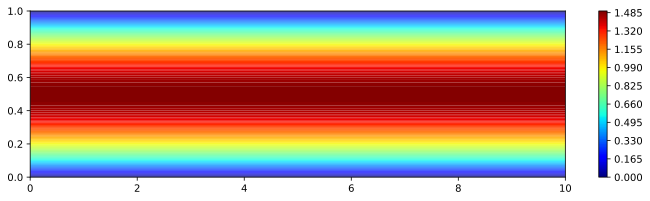

In [20]:
fig = plt.figure(figsize=(12,3),dpi=600)
CS = plt.contourf(x[1:ny+2,1:nx+2],y[1:ny+2,1:nx+2],Vel_mag[1:ny+2,1:nx+2],levels=101,cmap='jet')
plt.colorbar(CS);
#plt.clabel(CS,fontsize=10,inline=1,fmt='%3.2f');
plt.savefig('Vel_mag_cont.png');

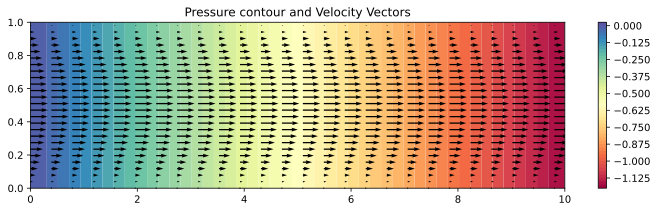

In [23]:
fig = plt.figure(figsize=[12,3],dpi=600)
#ax = plt.subplot(1,2,1)
pcont = plt.contourf(x[1:ny+2,1:nx+2],y[1:ny+2,1:nx+2],p_nodal[1:ny+2,1:nx+2],levels=51, cmap=plt.cm.Spectral)
plt.colorbar(pcont)

plt.quiver(x[1:ny+2:2,1:nx+2:2],y[1:ny+2:2,1:nx+2:2],u_nodal[1:ny+2:2,1:nx+2:2],v_nodal[1:ny+2:2,1:nx+2:2],color='black')
#plt.streamplot(x[1:ny+2,1:nx+2],y[1:ny+2,1:nx+2],u_nodal[1:ny+2,1:nx+2],v_nodal[1:ny+2,1:nx+2],color='blue')
plt.xlim([0,10])
plt.ylim([0,1])
plt.title('Pressure contour and Velocity Vectors')
#plt.axis('equal')
plt.savefig('Quiver_Plot.png')

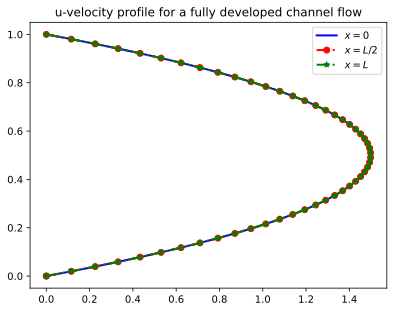

In [33]:
fig = plt.figure(dpi=600)
plt.plot(u_nodal[:,1],y[:,1],'b-',lw=2)
plt.plot(u_nodal[:,int(nx/2)],y[:,int(nx/2)],'r-.o',lw=2)
plt.plot(u_nodal[:,-1],y[:,-1],'g-.*',lw=2)
#plt.plot(x[int(ny/2),:],v_nodal[int(ny/2),:])
plt.legend(['$x=0$','$x=L/2$','$x=L$'])
#plt.axis('equal')
plt.title('u-velocity profile for a fully developed channel flow')
plt.savefig('Fully_Developed_Vel_Profile.png')

# Try it yourself 

What effect does increasing the Reynolds number have on the centerline velocity for the channel flow problem?

Increasing the Reynolds number decreases the centerline velocity at the exit as the flow is not fully developed at significantly higher Reynolds numbers.